# Programa principal

## Imports y variables globales

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

import sklearn
from sklearn import preprocessing
from sklearn import compose
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from matplotlib import pyplot as plt

data_url = "https://raw.githubusercontent.com/BoscoDomingo/ML-P1/main/data/"
csv_filenames = ["audi.csv","bmw.csv", "cclass.csv", "focus.csv", "ford.csv" , "hyundi.csv", "merc.csv", "skoda.csv", "toyota.csv", "vauxhall.csv", "vw.csv"]
# There is no elegant solution to this yet. Google and Microsoft, pls.
random_state = 1337

## Lectura de datos

In [ ]:
df = pd.DataFrame(columns=["brand"])
for file in csv_filenames:
    partial_df = pd.read_csv(f"{data_url}{file}")
    # Fix "tax" column
    if "tax(£)" in partial_df:
        partial_df.rename(columns={"tax(£)":"tax"}, inplace=True)
    partial_df["brand"] = file.split(".")[0]
    df = pd.concat([df, partial_df])
# Ensure correct data type
df.infer_objects()
df.year = pd.to_numeric(df.year, downcast='unsigned')

## Análisis de Datos y Preprocesamiento
Analizamos el DataFrame resultante de unificar los datos

In [ ]:
df_backup = df.copy() # Backup so as not to have to re-read CSVs all the time

# Price goes first for easier data treatment later on
df = df[['price', 'brand', 'model', 'year', 'transmission', 'mileage',
       'fuelType', 'tax', 'mpg', 'engineSize']]

In [ ]:
df_backup.describe()

,year,price,mileage,tax,mpg,engineSize
count,108540.000000,108540.000000,108540.000000,99187.000000,99187.000000,108540.000000
mean,2017.098028,16890.124046,23025.928469,120.299838,55.166825,1.661644
std,2.130057,9756.266820,21176.423684,63.150926,16.138522,0.557058
min,1970.000000,450.000000,1.000000,0.000000,0.300000,0.000000
25%,2016.000000,10229.500000,7491.750000,125.000000,47.100000,1.200000
50%,2017.000000,14698.000000,17265.000000,145.000000,54.300000,1.600000
75%,2019.000000,20940.000000,32236.000000,145.000000,62.800000,2.000000
max,2060.000000,159999.000000,323000.000000,580.000000,470.800000,6.600000


In [ ]:
df.head(10)

,brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,audi,A1,2017,12500.0,Manual,15735.0,Petrol,150.0,55.4,1.4
1,audi,A6,2016,16500.0,Automatic,36203.0,Diesel,20.0,64.2,2.0
2,audi,A1,2016,11000.0,Manual,29946.0,Petrol,30.0,55.4,1.4
3,audi,A4,2017,16800.0,Automatic,25952.0,Diesel,145.0,67.3,2.0
4,audi,A3,2019,17300.0,Manual,1998.0,Petrol,145.0,49.6,1.0
5,audi,A1,2016,13900.0,Automatic,32260.0,Petrol,30.0,58.9,1.4
6,audi,A6,2016,13250.0,Automatic,76788.0,Diesel,30.0,61.4,2.0
7,audi,A4,2016,11750.0,Manual,75185.0,Diesel,20.0,70.6,2.0
8,audi,A3,2015,10200.0,Manual,46112.0,Petrol,20.0,60.1,1.4
9,audi,A1,2016,12000.0,Manual,22451.0,Petrol,30.0,55.4,1.4


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


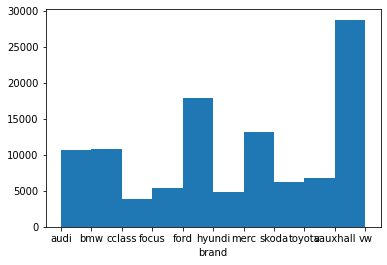

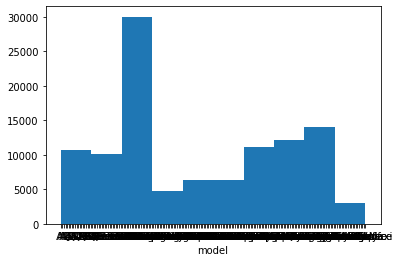

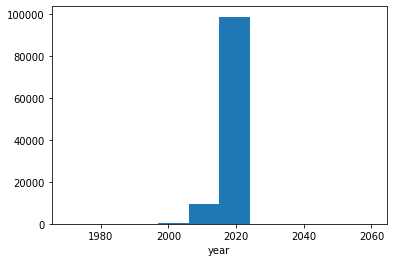

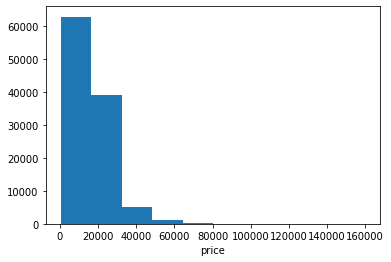

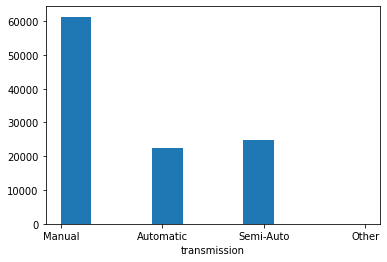

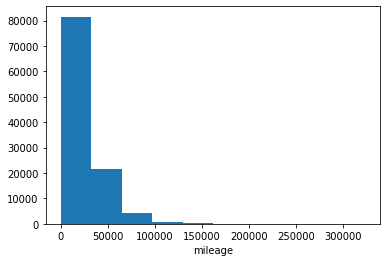

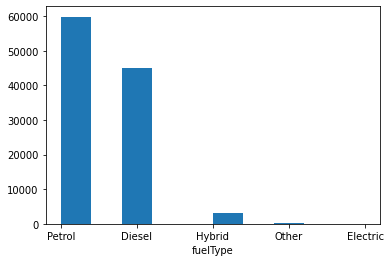

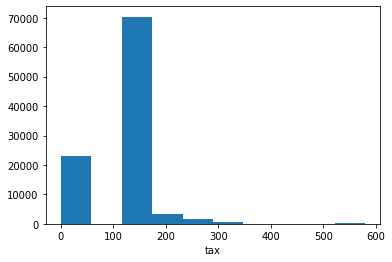

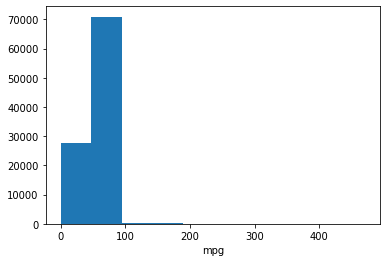

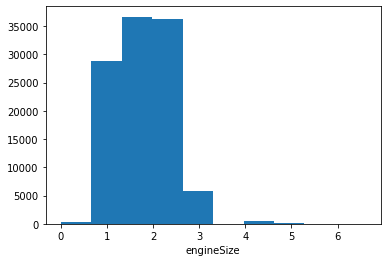

In [ ]:
for column in df_backup.columns:
    plt.figure()
    plt.xlabel(column)
    plt.hist(df_backup[column])

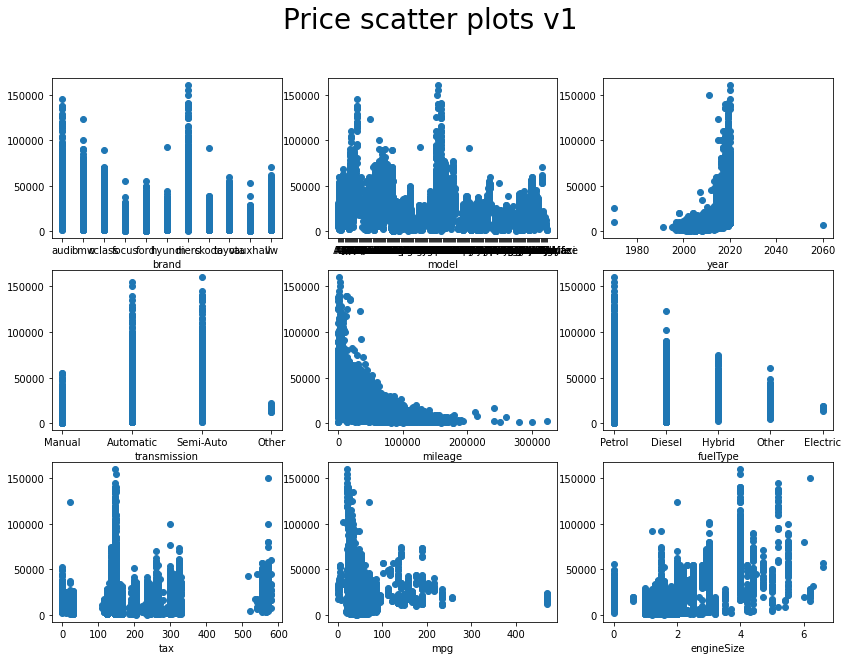

In [ ]:
index = 1
plt.figure(figsize=(14,10))
plt.suptitle('Price scatter plots v1', size = 28);
for column in df_backup.columns:
    if column == "price":
        continue
    plt.subplot(3,3,index)
    plt.scatter(df_backup[column], df_backup['price'])
    plt.xlabel(column)
    index += 1

# Source: https://datascience.stackexchange.com/a/31755

#### Anomalías observadas

*   Las columnas `tax` y `tax(£)` (que unificamos en el proceso de lectura) 
*   `year` superiores a 2020 (imposible) y un par de valores muy bajos, cuando la gran mayoría son del 2000 en adelante
*   `engineSize` con valor 0 (imposible)
*   `mpg` con valores imposibles (menores a 11 MPG o superiores a 94 MPG)
*   `mileage` con valores extremadamente altos y bajos



#### Filtrado inicial


1.   Eliminar filas con valores en `year` superiores a 2020 (que son imposibles) y eliminar los valores menores a 2000 (que son un par de unidades y pueden causar problemas)
2.   Eliminar filas con valores en `engineSize` menores que 1 (no existen coches con tamaño menor a 1L)
3.   Eliminar anomalías en `mpg` y `mileage` tomando sólo las filas que caigan dentro de µ ± 2σ (asumiendo una distribución normal esto sería el 95% de los casos en torno a la media)





In [ ]:
# Filtering year
df = df[(df["year"] <= 2020) & (df["year"] >= 2000) ]

# Filtering engineSize
df = df[df["engineSize"] >= 0.5]

# Reducing sample size by mpg and mileage
df = df[(df.mpg > df.mpg.quantile(.025)) & (df.mpg < df.mpg.quantile(.975)) & (df.mileage > df.mileage.quantile(.025)) & (df.mileage < df.mileage.quantile(.975))]

##### Resultados tras las primeras operaciones

In [ ]:
df.describe()

,price,year,mileage,tax,mpg,engineSize
count,88823.000000,88823.000000,88823.000000,88823.000000,88823.000000,88823.000000
mean,16247.740157,2017.128807,21855.885075,119.769767,54.665994,1.631308
std,8469.392389,1.850414,17063.745290,58.631178,10.027034,0.507144
min,795.000000,2000.000000,101.000000,0.000000,32.900000,1.000000
25%,10000.000000,2016.000000,8230.000000,125.000000,47.100000,1.200000
50%,14250.000000,2017.000000,17753.000000,145.000000,54.300000,1.500000
75%,20000.000000,2019.000000,31505.000000,145.000000,61.700000,2.000000
max,123456.000000,2020.000000,78990.000000,330.000000,78.000000,5.000000


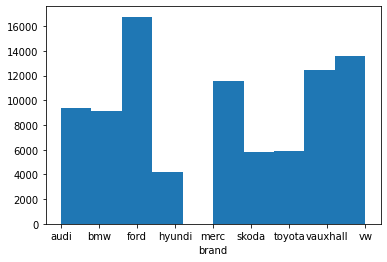

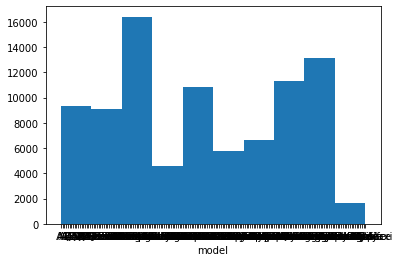

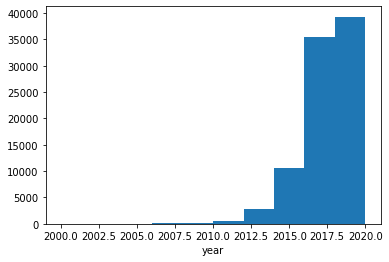

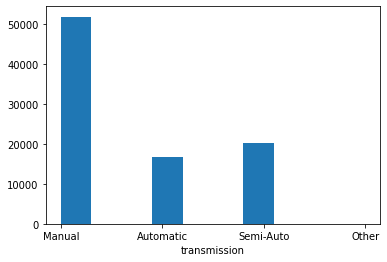

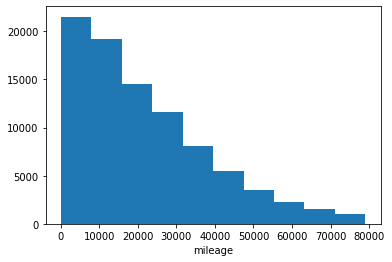

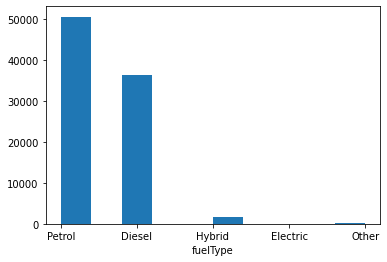

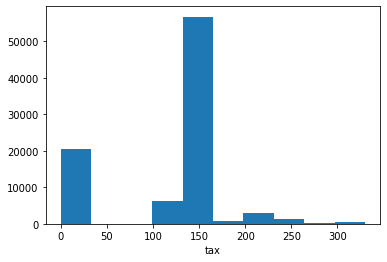

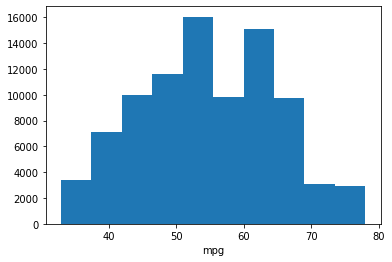

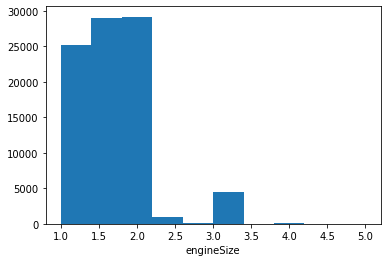

In [ ]:
for column in df.columns[1:]:
    plt.figure()
    plt.xlabel(column)
    plt.hist(df[column])

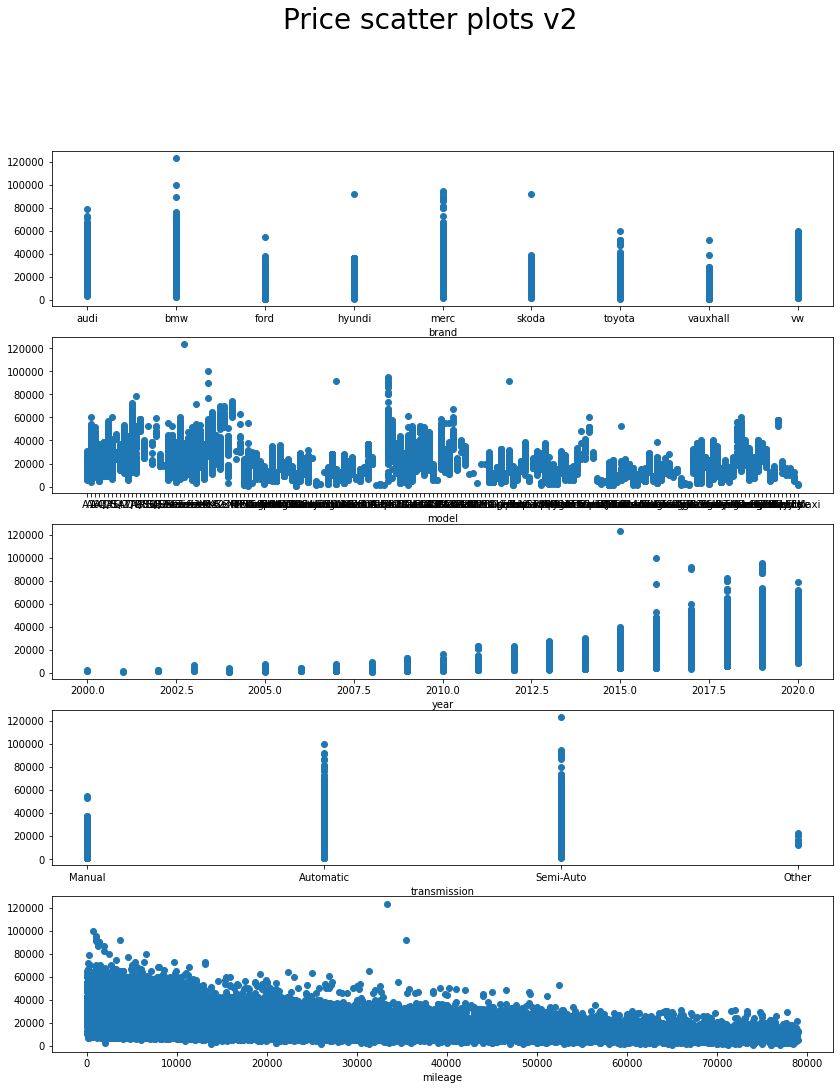

In [ ]:
index = 1
plt.figure(figsize=(14,20))
plt.suptitle('Price scatter plots v2', size = 28);
for column in df.columns[:6]:
    if column == "price":
        continue
    plt.subplot(6,1,index)
    plt.scatter(df[column], df['price'])
    plt.xlabel(column)
    index += 1

# Source: https://datascience.stackexchange.com/a/31755

### Procesado de datos
Tras ver los histogramas, decidimos procesar features a fin de obtener escalas similares y normalizar aquellos valores que consideramos nos pueden aportar utilidad

### Reescalado

In [ ]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df['year'] = min_max_scaler.fit_transform(df[['year']])

# The ones below didn't bring any performance increases
#df['tax'] = min_max_scaler.fit_transform(df[['tax']])
#df['engineSize'] = min_max_scaler.fit_transform(df[['engineSize']])
#df['mpg'] = min_max_scaler.fit_transform(df[['mpg']])
#df['mileage'] = min_max_scaler.fit_transform(df[['mileage']])

In [ ]:
df.describe()

,price,year,mileage,tax,mpg,engineSize
count,88823.000000,88823.000000,88823.000000,88823.000000,88823.000000,88823.000000
mean,16247.740157,0.856440,21855.885075,119.769767,54.665994,1.631308
std,8469.392389,0.092521,17063.745290,58.631178,10.027034,0.507144
min,795.000000,0.000000,101.000000,0.000000,32.900000,1.000000
25%,10000.000000,0.800000,8230.000000,125.000000,47.100000,1.200000
50%,14250.000000,0.850000,17753.000000,145.000000,54.300000,1.500000
75%,20000.000000,0.950000,31505.000000,145.000000,61.700000,2.000000
max,123456.000000,1.000000,78990.000000,330.000000,78.000000,5.000000


### One-Hot Encoding
*One-Hot Encoder* a las clases `brand`, `model`, `transmission`, `fuelType`

In [ ]:
# One-Hot Encoder
for column_name, prefix in {"brand":"", "model":"model", "transmission": "gearbox", "fuelType":"fuel"}.items():
    if prefix:
        df = pd.concat([df, pd.get_dummies(df[column_name], prefix=prefix)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[column_name])], axis=1)
    df.drop([column_name], axis=1, inplace=True)

In [ ]:
df.head()

,price,year,mileage,tax,mpg,engineSize,audi,bmw,ford,hyundi,merc,skoda,toyota,vauxhall,vw,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,model_ 7 Series,model_ 8 Series,model_ A Class,model_ A1,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Accent,model_ Adam,model_ Agila,model_ Amarok,model_ Amica,model_ Antara,model_ Arteon,model_ Astra,model_ Auris,...,model_ Touran,model_ Tourneo Connect,model_ Tourneo Custom,model_ Transit Tourneo,model_ Tucson,model_ Up,model_ Urban Cruiser,model_ V Class,model_ Vectra,model_ Veloster,model_ Verso,model_ Verso-S,model_ Viva,model_ Vivaro,model_ X-CLASS,model_ X1,model_ X2,model_ X3,model_ X4,model_ X5,model_ X6,model_ X7,model_ Yaris,model_ Yeti,model_ Yeti Outdoor,model_ Z4,model_ Zafira,model_ Zafira Tourer,model_180,model_200,model_220,gearbox_Automatic,gearbox_Manual,gearbox_Other,gearbox_Semi-Auto,fuel_Diesel,fuel_Electric,fuel_Hybrid,fuel_Other,fuel_Petrol
0,12500.0,0.85,15735.0,150.0,55.4,1.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,16500.0,0.80,36203.0,20.0,64.2,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,11000.0,0.80,29946.0,30.0,55.4,1.4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,16800.0,0.85,25952.0,145.0,67.3,2.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
4,17300.0,0.95,1998.0,145.0,49.6,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


### Resultados finales

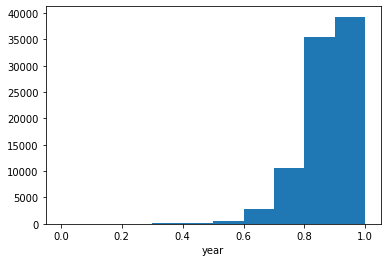

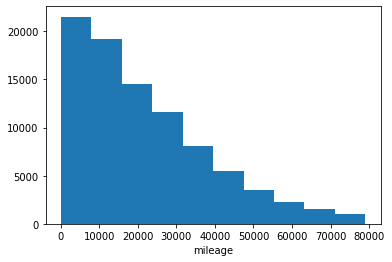

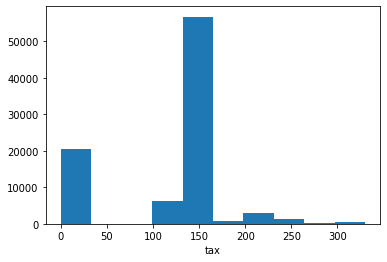

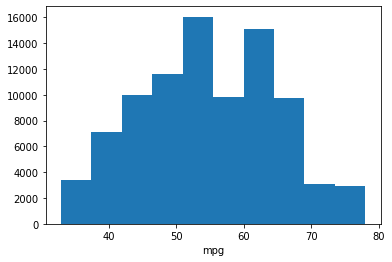

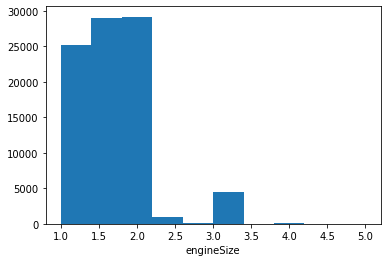

In [ ]:
for column in df.columns[1:6]:
    plt.figure()
    plt.xlabel(column)
    plt.hist(df[column])

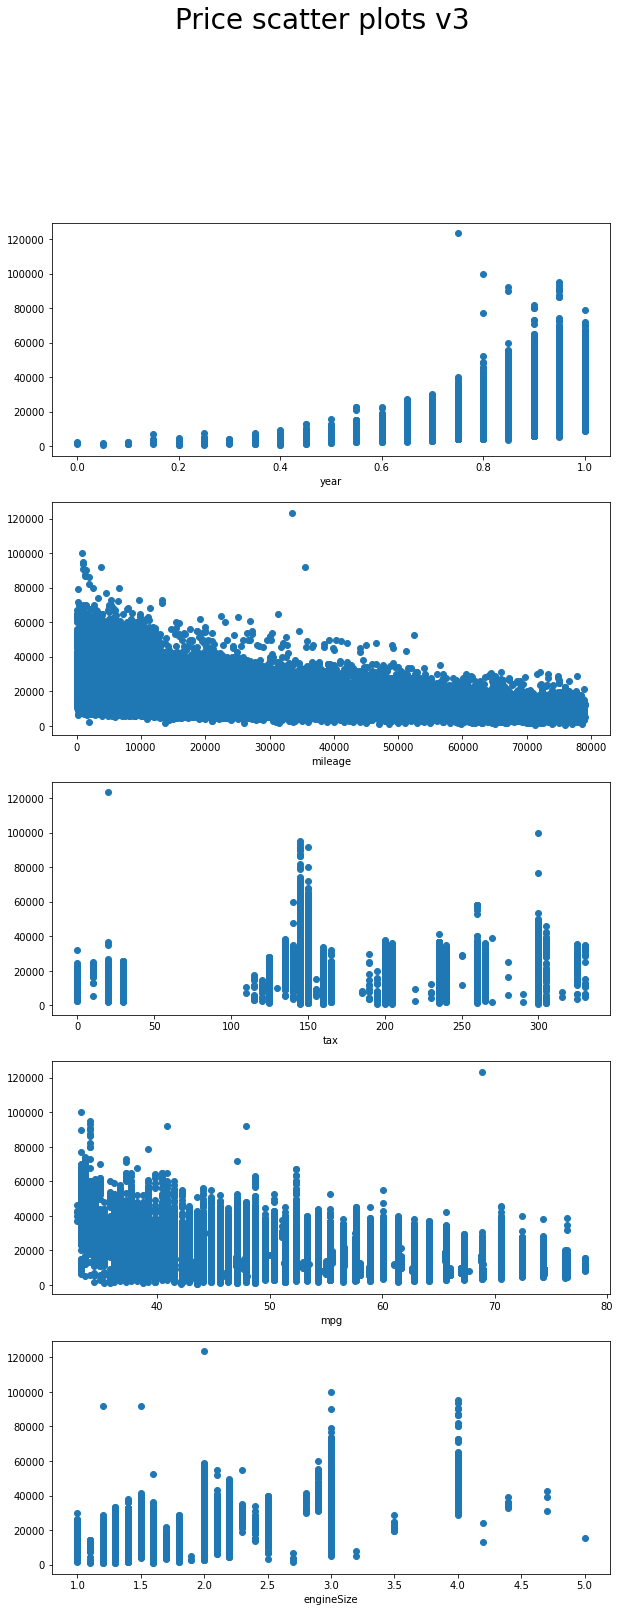

In [ ]:
index = 1
plt.figure(figsize=(10,30))
plt.suptitle('Price scatter plots v3', size = 28);
for column in df.columns[:6]:
    if column == "price":
        continue
    plt.subplot(6,1,index)
    plt.scatter(df[column], df['price'])
    plt.xlabel(column)
    index += 1

# Source: https://datascience.stackexchange.com/a/31755

### Obtener X e y (X_train, X_test, y_train, y_test)

In [ ]:
X = np.array(df.iloc[:, 1:])
X

array([[8.5000e-01, 1.5735e+04, 1.5000e+02, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [8.0000e-01, 3.6203e+04, 2.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [8.0000e-01, 2.9946e+04, 3.0000e+01, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [6.0000e-01, 7.4000e+04, 1.2500e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.5000e-01, 7.0000e+04, 2.0000e+02, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [3.5000e-01, 7.4000e+04, 1.4500e+02, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00]])

In [ ]:
y = np.array(df['price'])
y

array([12500., 16500., 11000., ...,  5990.,  1590.,  2295.])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Optimización de hiperparámetros mediante GridSearch con Cross Validation



In [ ]:
# Parameter cv is 5 by default, adding more scoring methods would make it take too long to train
ridge_grid = GridSearchCV(
    Ridge(),
    {
        'alpha': (0.001, 0.005, 0.01), # Started with (0.001, 0.01, 0.1, 0.5, 0.9, 0.99)
        'max_iter': (10,50,100), # Started with (500, 1000, 1500)
    },
    scoring= ('neg_mean_absolute_error', "neg_root_mean_squared_error"),
    refit = 'neg_mean_absolute_error',
    n_jobs=-1,
)
lasso_grid = GridSearchCV(
    Lasso(),
    {
        'alpha': (0.01, 0.1), # Started with (0.01, 0.1, 1)
        'max_iter': (1500, 2000), # Started with (500, 1000, 1500)
    },
    scoring= ('neg_mean_absolute_error', "neg_root_mean_squared_error"),
    refit = 'neg_mean_absolute_error',
    n_jobs=-1
)
elastic_net_grid = GridSearchCV(
    ElasticNet(),
    {
        'alpha': (0.01, 0.02), # Started with (0.01, 0.1, 1)
        'l1_ratio': (0.01, 0.5, 0.99), # Started with np.linspace(0.15, 0.85, 3),
        'max_iter': (1500, 2000), # Started with (500, 1000)
    },
    scoring= ('neg_mean_absolute_error', "neg_root_mean_squared_error"),
    refit = 'neg_mean_absolute_error',
    n_jobs=-1
)

## Modelos Machine Learning


In [ ]:
linear = LinearRegression().fit(X_train, y_train)

In [ ]:
with tf.device('/device:GPU:0'):
    print("Ridge - Training")
    ridge_grid.fit(X_train, y_train)
    print("Ridge - DONE")

Ridge - Training
Ridge - DONE


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32642e-17): result may not be accurate.
  overwrite_a=True).T


In [ ]:
with tf.device('/device:GPU:0'):
    print("Lasso - Training")
    lasso_grid.fit(X_train, y_train)
    print("Lasso - DONE")

Lasso - Training
Lasso - DONE


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 285083966805.3552, tolerance: 507560951.85202056
  positive)


In [ ]:
with tf.device('/device:GPU:0'):
    print("Elastic Net - Training")
    elastic_net_grid.fit(X_train, y_train)
    print("Elastic Net - DONE")
    # It simply became a Lasso function when we last tried

Elastic Net - Training
Elastic Net - DONE


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197190686404.9616, tolerance: 507560951.85202056
  positive)


### Scoring

In [ ]:
print("Lineal:\n\tMAE")
print(f"\t\ttrain:\t{mean_absolute_error(y_train, linear.predict(X_train))}")
print(f"\t\ttest:\t{mean_absolute_error(y_test, linear.predict(X_test))}")
print("\tRMSE")
print(f"\t\ttrain:\t{mean_squared_error(y_train, linear.predict(X_train))**0.5}")
print(f"\t\ttest:\t{mean_squared_error(y_test, linear.predict(X_test))**0.5}")
print("\tR2")
print(f"\t\ttrain:\t{r2_score(y_train, linear.predict(X_train))}")
print(f"\t\ttest:\t{r2_score(y_test, linear.predict(X_test))}")

print('\n\t------\n')

print("Ridge:\n\tMAE")
print(f"\t\ttrain:\t{mean_absolute_error(y_train, ridge_grid.predict(X_train))}")
print(f"\t\ttest:\t{mean_absolute_error(y_test, ridge_grid.predict(X_test))}")
print("\tRMSE")
print(f"\t\ttrain:\t{mean_squared_error(y_train, ridge_grid.predict(X_train))**0.5}")
print(f"\t\ttest:\t{mean_squared_error(y_test, ridge_grid.predict(X_test))**0.5}")
print("\tR2")
print(f"\t\ttrain:\t{r2_score(y_train, ridge_grid.predict(X_train))}")
print(f"\t\ttest:\t{r2_score(y_test, ridge_grid.predict(X_test))}")

print('\n\t------\n')

print("Lasso:\n\tMAE")
print(f"\t\ttrain:\t{mean_absolute_error(y_train, lasso_grid.predict(X_train))}")
print(f"\t\ttest:\t{mean_absolute_error(y_test, lasso_grid.predict(X_test))}")
print("\tRMSE")
print(f"\t\ttrain:\t{mean_squared_error(y_train, lasso_grid.predict(X_train))**0.5}")
print(f"\t\ttest:\t{mean_squared_error(y_test, lasso_grid.predict(X_test))**0.5}")
print("\tR2")
print(f"\t\ttrain:\t{r2_score(y_train, lasso_grid.predict(X_train))}")
print(f"\t\ttest:\t{r2_score(y_test, lasso_grid.predict(X_test))}")


print('\n\t------\n')

print("Elastic Net:\n\tMAE")
print(f"\t\ttrain:\t{mean_absolute_error(y_train, elastic_net_grid.predict(X_train))}")
print(f"\t\ttest:\t{mean_absolute_error(y_test, elastic_net_grid.predict(X_test))}")
print("\tRMSE")
print(f"\t\ttrain:\t{mean_squared_error(y_train, elastic_net_grid.predict(X_train))**0.5}")
print(f"\t\ttest:\t{mean_squared_error(y_test, elastic_net_grid.predict(X_test))**0.5}")
print("\tR2")
print(f"\t\ttrain:\t{r2_score(y_train, elastic_net_grid.predict(X_train))}")
print(f"\t\ttest:\t{r2_score(y_test, elastic_net_grid.predict(X_test))}")


Lineal:
	MAE
		train:	1953.680249096138
		test:	1956.3277222429501
	RMSE
		train:	2853.2049886273153
		test:	2805.3906113339826
	R2
		train:	0.8860299533956781
		test:	0.8920882890613466

	------

Ridge:
	MAE
		train:	1953.6819288355275
		test:	1956.3288202636948
	RMSE
		train:	2853.204990520116
		test:	2805.389677922458
	R2
		train:	0.8860299532444639
		test:	0.8920883608702544

	------

Lasso:
	MAE
		train:	1953.8778697155115
		test:	1956.3525941993028
	RMSE
		train:	2853.229614188824
		test:	2806.2219853459724
	R2
		train:	0.8860279860722537
		test:	0.8920243205821164

	------

Elastic Net:
	MAE
		train:	1953.8911367574938
		test:	1956.3780191324531
	RMSE
		train:	2853.2296400709142
		test:	2806.2573588396085
	R2
		train:	0.886027984004538
		test:	0.8920215984160856


# Conclusión:
Tras haber realizado el procesamiento de datos, haber hecho optimización de hiperparámetros con GridSearchCV, y haber entrenado los modelos con los datos, comparando los scores (MAE, RMSE y R²) se puede observar que los modelos Linear, Ridge y Lasso son los que mejores resultados ofrecen, descartando Elastic Net debido a su alto error en comparación con estos modelos (cuando no se convierte directamente en una Lasso, en cuyo caso es más útil emplear dicho modelo directamente).

A partir de aquí, ya obtendríamos el modelo que más se ajustase a nuestros requisitos, con los parámetros más óptimos, y podríamos emplear dicho modelo para que sea capaz de predecir los precios de los coches.

# Testing

## Análisis de datos

In [ ]:
df_backup.brand.nunique() # should be 11

In [ ]:
df_backup.fuelType.describe()

In [ ]:
df_backup.transmission.describe()

In [ ]:
df_backup.transmission.unique()

In [ ]:
df_backup.fuelType.unique()

In [ ]:
print(sorted(df_backup.year.unique())) # To detect the anomaly

In [ ]:
len(X)

In [ ]:
pd.plotting.scatter_matrix(df_backup, alpha=0.2, figsize=(20,20))

In [ ]:
# We found a more efficient way to do it
column_transformer = sklearn.compose.ColumnTransformer(transformers=[
    ("scale", sklearn.preprocessing.StandardScaler(), [0]),
    ("passthrough", "passthrough", [1]),
    ("scale", sklearn.preprocessing.StandardScaler(), [2]),
    ("min-max", sklearn.preprocessing.MinMaxScaler(), [3]),
    ("one-hot", sklearn.preprocessing.OneHotEncoder(), [4])
]);

In [ ]:
# Doesn't work
sigma = df_backup.describe().loc['std'][0]
mean = df_backup.describe().loc['mean'][0]
df_backup[(df_backup["mpg"] > mean - 2*sigma) & (df_backup["mpg"] < mean + 2*sigma)].describe()

In [ ]:
df_backup[(df_backup.mpg > df_backup.mpg.quantile(.025)) & (df_backup.mpg < df_backup.mpg.quantile(.975))].describe()

In [ ]:
df_backup[df_backup["mpg"] == 11].head()

In [ ]:
df_backup[(df_backup["mpg"] > 11) & (df_backup["mpg"] <= 94)].describe()

In [ ]:
df_backup[df_backup["mileage"] > 250000].head()

In [ ]:
df_backup[(df_backup.tax >= df_backup.tax.quantile(.003)) & (df_backup.tax <= df.tax.quantile(.997))].describe()

In [ ]:
print(sorted(df_backup.engineSize.unique()))

In [ ]:
# Plotting experiment
import seaborn as sns
sns.pairplot(data=df_backup,y_vars=['price'],x_vars=df_backup.columns)
# Source: https://stackoverflow.com/a/43322569/9022642

In [ ]:
# K-FOLDS CV to train Linear Reg. resulted in worse performance
print(f"\tMAE: {np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))}")
print(f"\tMSE: {np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='neg_mean_squared_error'))}")
print(f"\tRMSE: {np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=5, scoring='neg_root_mean_squared_error'))}")

	MAE: -3589.8091724859087
	MSE: -24889914.731730696
	RMSE: -4953.063697084142


## Normalización

In [ ]:
# Normalisation (l1, l2, max) for this dataset doesn't give any advantages and in fact makes the data somewhat weird
# So we didn't apply it despite Linear Regression assuming Normal distributions
norm = 'l2'
df['engineSize'] = sklearn.preprocessing.normalize(np.array(df['engineSize']).reshape(-1, 1), norm=norm)
df['tax'] = sklearn.preprocessing.normalize(np.array(df['tax']).reshape(-1, 1), norm=norm)
df['mpg'] = sklearn.preprocessing.normalize(np.array(df['mpg']).reshape(-1, 1), norm=norm)
df['mileage'] = sklearn.preprocessing.normalize(np.array(df['mileage']).reshape(-1, 1), norm=norm)

,price,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,12500.0,audi,A1,0.85,Manual,1.0,Petrol,1.0,1.0,1.0
1,16500.0,audi,A6,0.80,Automatic,1.0,Diesel,1.0,1.0,1.0
2,11000.0,audi,A1,0.80,Manual,1.0,Petrol,1.0,1.0,1.0
3,16800.0,audi,A4,0.85,Automatic,1.0,Diesel,1.0,1.0,1.0
4,17300.0,audi,A3,0.95,Manual,1.0,Petrol,1.0,1.0,1.0
5,13900.0,audi,A1,0.80,Automatic,1.0,Petrol,1.0,1.0,1.0
6,13250.0,audi,A6,0.80,Automatic,1.0,Diesel,1.0,1.0,1.0
7,11750.0,audi,A4,0.80,Manual,1.0,Diesel,1.0,1.0,1.0
8,10200.0,audi,A3,0.75,Manual,1.0,Petrol,1.0,1.0,1.0
9,12000.0,audi,A1,0.80,Manual,1.0,Petrol,1.0,1.0,1.0


## Estandarización

In [ ]:
# Tried even though it's not a normal distribution
df['mpg'] = sklearn.preprocessing.scale(df['mpg'])

## Iteraciones de grid search


In [ ]:
ridge_grid.best_estimator_

Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge_grid.best_score_

-1961.2406611644942

In [ ]:
lasso_grid.best_estimator_

Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1500,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso_grid.best_score_

-1961.377744970853

In [ ]:
elastic_net_grid.best_estimator_ # It went full Lasso

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=1.0,
           max_iter=1500, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
elastic_net_grid.best_score_

-1961.377744970853

In [ ]:
ridge_grid_train = GridSearchCV(
    Ridge(),
    {
        'alpha': (0.001, 0.01, 0.1, 0.5, 0.9, 0.99),
        'max_iter': (500, 1000, 1500),
    },
    scoring= ('neg_mean_absolute_error', "neg_root_mean_squared_error"),
    refit = 'neg_mean_absolute_error',
    n_jobs=-1,
)

ridge_grid_train.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.32705e-17): result may not be accurate.
  overwrite_a=True).T


GridSearchCV(cv=None, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': (0.001, 0.01, 0.1, 0.5, 0.9, 0.99),
                         'max_iter': (500, 1000, 1500)},
             pre_dispatch='2*n_jobs', refit='neg_mean_absolute_error',
             return_train_score=False,
             scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error'),
             verbose=0)

In [ ]:
print(ridge_grid_train.best_score_*-1)
print(mean_absolute_error(y_test, ridge_grid_train.predict(X_test)))

1961.2406558534974
1956.3288162603346


In [ ]:
mean_absolute_error(y_test, ridge_grid.predict(X_test))

1994.7971078138198

In [ ]:
ridge = Ridge(alpha=0.01, max_iter=1000)
ridge.fit(X,y)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
mean_absolute_error(y_test, ridge.predict(X_test))

1988.1353788168187

# Referencias

1.   https://www.inchcape.co.uk/blog/guides/what-size-engine-do-i-need/
2.   https://motorway.co.uk/guides/best-cars-for-mpg
3.   https://www.caranddriver.com/features/g30256394/worst-fuel-economy-cars/?slide=1

